In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import math
#from geopy import distance
#from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_folder = './data/'

# Method returning the dataframe obtained from the csv file named "name".
def get_dataframe(name):
    return pd.read_csv(data_folder + name, compression='gzip', sep='\t',header = None)

b_edges = get_dataframe('loc-brightkite_edges.txt.gz')
brightkite_checkins = get_dataframe('loc-brightkite_totalCheckins.txt.gz')
g_edges = get_dataframe('loc-gowalla_edges.txt.gz')
gowalla_checkins = get_dataframe('loc-gowalla_totalCheckins.txt.gz')


In [4]:
#Renaming the columns in the given dataframes with the names given.
b_checkins = brightkite_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})
g_checkins = gowalla_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})

#Checking the number of checkins we have in each dataframe.
print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))
b_checkins.head()

Number of checkins in Brightkite: 4747287
Number of checkins in Gowalla: 6442892


,user,checkin_time,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc


In [6]:
# Checking for rows with impossible longitudes/latitudes and removing them if needed.

max_abs_latitude = 90
max_abs_longitude = 180

# Method verifying that the longitude and latitude values of row are valid.
def check_lat_long(row):
    return ((abs(row['latitude']) <= max_abs_latitude) & (abs(row['longitude']) <= max_abs_longitude))

# Any row with a "False" value for check_lat_long will be dropped from the dataframe.
b_checkins = b_checkins[b_checkins.apply(lambda row: check_lat_long(row), axis=1)]
g_checkins = g_checkins[g_checkins.apply(lambda row: check_lat_long(row), axis=1)]

print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))

Number of checkins in Brightkite: 4747172
Number of checkins in Gowalla: 6442863


In [7]:
# Creating a mask for all checkin locations that are not (0,0).
b_non_zero_mask = b_checkins.apply(lambda x : (x['latitude']!=0)&(x['longitude']!=0),axis = 1)
g_non_zero_mask = g_checkins.apply(lambda x : (x['latitude']!=0)&(x['longitude']!=0),axis = 1)

print("There are " + str((b_non_zero_mask == False).sum()) + " checkins with (0,0) as coordinates pair.")

There are 256207 checkins with (0,0) as coordinates pair.


In [8]:
# Filtering out all the checkins made at location (lat,long) = (0,0).
b_checkins = b_checkins[b_non_zero_mask]
g_checkins = g_checkins[g_non_zero_mask]
#b_checkins.head()

In [18]:
usa_top_right = (49, -60.128423) #USA without Alaska nor Hawaii
usa_bottom_left = (24.539159, -125.325272)
uk_top_right = (59.159002, 2.103343) #UK and Ireland
uk_bottom_left = (49.587963, -10.512021)
france_top_right = (42.978949, -4.601638) #Metropolitan France
france_bottom_left = (36.813173, -26.510956)
spain_top_right = (43.050887, 3.940208) # Spain and Portugal
spain_bottom_left = (35.903991, -9.446662) #done
sweden_top_right = (68.997577, 21.011374) #Sweden, Norway and Danmark
sweden_bottom_left = (54.996107, 4.980256)
germany_top_right = (54.918628, 14.634344)
germany_bottomn_left = (47.286913, 6.896869)
japan_top_right = (45.652509, 145.745126) #Japan and Korea
japan_bottomn_left = (29.895673, 125.792187)


usa = [usa_bottom_left, usa_top_right]
uk = [uk_bottom_left, uk_top_right]
france = [france_bottom_left, france_top_right]
spain = [spain_bottom_left, spain_top_right]
sweden = [sweden_bottom_left, sweden_top_right]
germany = [germany_bottomn_left, germany_top_right]
japan = [japan_bottomn_left, japan_top_right]

In [12]:
def is_in_country(row, country):
    country_lat_range = range(int(country[0][0]), int(country[1][0])+1)
    country_long_range = range(int(country[0][1]), int(country[1][1])+1)
    return (int(row['latitude']) in country_lat_range) & (int(row['longitude']) in country_long_range)

In [15]:
b_checkins['is_in_spain'] = b_checkins.apply(lambda row: is_in_country(row, spain), axis=1)
g_checkins['is_in_spain'] = g_checkins.apply(lambda row: is_in_country(row, spain), axis=1)

#b_checkins.head()

In [16]:
b_checkins['is_in_uk'] = b_checkins.apply(lambda row: is_in_country(row, uk), axis=1)
g_checkins['is_in_uk'] = g_checkins.apply(lambda row: is_in_country(row, uk), axis=1)

#b_checkins.head()

In [17]:
b_checkins['is_in_france'] = b_checkins.apply(lambda row: is_in_country(row, france), axis=1)
g_checkins['is_in_france'] = g_checkins.apply(lambda row: is_in_country(row, france), axis=1)

#b_checkins.head()

In [20]:
b_checkins['is_in_usa'] = b_checkins.apply(lambda row: is_in_country(row, usa), axis=1)
g_checkins['is_in_usa'] = g_checkins.apply(lambda row: is_in_country(row, usa), axis=1)

b_checkins.head()

,user,checkin_time,latitude,longitude,location_id,is_in_spain,is_in_uk,is_in_france,is_in_usa
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,False,False,False,True
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,False,False,False,True
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,False,False,False,True
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,False,False,False,True
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,False,False,False,True


In [21]:
b_checkins['is_in_sweden'] = b_checkins.apply(lambda row: is_in_country(row, sweden), axis=1)
g_checkins['is_in_sweden'] = g_checkins.apply(lambda row: is_in_country(row, sweden), axis=1)

b_checkins.head()

,user,checkin_time,latitude,longitude,location_id,is_in_spain,is_in_uk,is_in_france,is_in_usa,is_in_sweden
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,False,False,False,True,False
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,False,False,False,True,False
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,False,False,False,True,False
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,False,False,False,True,False
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,False,False,False,True,False


In [22]:
b_checkins['is_in_germany'] = b_checkins.apply(lambda row: is_in_country(row, germany), axis=1)
g_checkins['is_in_germany'] = g_checkins.apply(lambda row: is_in_country(row, germany), axis=1)

b_checkins.head()

,user,checkin_time,latitude,longitude,location_id,is_in_spain,is_in_uk,is_in_france,is_in_usa,is_in_sweden,is_in_germany
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,False,False,False,True,False,False
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,False,False,False,True,False,False
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,False,False,False,True,False,False
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,False,False,False,True,False,False
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,False,False,False,True,False,False


In [23]:
b_checkins['is_in_japan'] = b_checkins.apply(lambda row: is_in_country(row, japan), axis=1)
g_checkins['is_in_japan'] = g_checkins.apply(lambda row: is_in_country(row, japan), axis=1)

b_checkins.head()

,user,checkin_time,latitude,longitude,location_id,is_in_spain,is_in_uk,is_in_france,is_in_usa,is_in_sweden,is_in_germany,is_in_japan
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,False,False,False,True,False,False,False
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,False,False,False,True,False,False,False
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,False,False,False,True,False,False,False
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,False,False,False,True,False,False,False
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,False,False,False,True,False,False,False


In [26]:
def checkin_outside_countries(row):
    return ((row['is_in_usa']==False) & (row['is_in_france']==False) 
            & (row['is_in_uk']==False) & (row['is_in_spain']==False) 
            & (row['is_in_germany']==False) & (row['is_in_sweden']==False) & (row['is_in_japan']==False))

b_checkins[b_checkins.apply(lambda row: checkin_outside_countries(row), axis=1)]
g_checkins[g_checkins.apply(lambda row: checkin_outside_countries(row), axis=1)]

KeyboardInterrupt: 

In [29]:
print(len(b_checkins[b_checkins['is_in_usa']]))
print(len(b_checkins[b_checkins['is_in_france']]))
print(len(b_checkins[b_checkins['is_in_uk']]))
print(len(b_checkins[b_checkins['is_in_spain']]))
print(len(b_checkins[b_checkins['is_in_germany']]))
print(len(b_checkins[b_checkins['is_in_sweden']]))
print(len(b_checkins[b_checkins['is_in_japan']]))
print(len(b_checkins[b_checkins['is_in_usa']]) + len(b_checkins[b_checkins['is_in_france']])
      + len(b_checkins[b_checkins['is_in_uk']]) + len(b_checkins[b_checkins['is_in_spain']])
      + len(b_checkins[b_checkins['is_in_germany']]) + len(b_checkins[b_checkins['is_in_sweden']])
      + len(b_checkins[b_checkins['is_in_japan']]))

2923138
17330
223947
59483
101067
104450
422944
3852359


In [30]:
print(len(g_checkins[g_checkins['is_in_usa']]))
print(len(g_checkins[g_checkins['is_in_france']]))
print(len(g_checkins[g_checkins['is_in_uk']]))
print(len(g_checkins[g_checkins['is_in_spain']]))
print(len(g_checkins[g_checkins['is_in_germany']]))
print(len(g_checkins[g_checkins['is_in_sweden']]))
print(len(g_checkins[g_checkins['is_in_japan']]))
print(len(g_checkins[g_checkins['is_in_usa']]) + len(g_checkins[g_checkins['is_in_france']])
      + len(g_checkins[g_checkins['is_in_uk']]) + len(g_checkins[g_checkins['is_in_spain']])
      + len(g_checkins[g_checkins['is_in_germany']]) + len(g_checkins[g_checkins['is_in_sweden']])
      + len(g_checkins[g_checkins['is_in_japan']]))

3675793
33888
281165
60633
437217
1111863
66734
5667293


#### Interprétation:

je pense que faire ensuite un texte sur le fait que va y avoir des checkins qui vont correspondre à deux pays mais que c’est pas trop grave parce que ça veut dire que c’est des zones limitrophes et donc que elles ont potentiellement des influences culturelles des deux pays, particulierement en europe c’est pas mal nan?

In [ ]:
b_checkins.to_csv(r'./data/b_checkins_with_countries.csv', compression='gzip')
g_checkins.to_csv(r'./data/g_checkins_with_countries.csv', compression='gzip')

Finding the homes of the users and classifying them in each continent

## Making the conversions

We create the different functions and constants needed for assigning the locations to cells.
The function get_cell_coordinates gives the wanted coordinates of the cell given the latitude and longitude.

In [157]:
#lat_deg_in_km is the coefficient of conversion of a latitude in degrees to latitude in kilometers
#side_of_square is the size of the side of the cells in the discretized world in kilometers
#long_deg_in_km is the constant coefficient of conversion of a longitude in degrees to kilometers

lat_deg_in_km = 110.574
side_of_square = 25
long_deg_in_km = 111.3290

In [158]:
#the function long_deg_to_km returns the total coefficent of conversion of a longitude in degrees to kilometers in function 
#of the latitude and long_deg_in_km
def long_deg_to_km(lat):
    return long_deg_in_km*np.cos(lat)


#get_cell_coordinates obtains the coordinates in the discretized world (squares of 25 by 25 km) from a location in
#latitude and longitude, we simply multiply the latitude by lat_deg_in_km and divide it by side_of_square
#and multiply the longitude by long_deg_to_km(lat) and divide it by side_of_square
def get_cell_coordinates(lat, long):
    x_coord = int((long*long_deg_to_km(lat))/side_of_square)
    y_coord = int((lat*lat_deg_in_km)/side_of_square)
    return (x_coord, y_coord)

## Assigning cells

Now we can assign to the locations the corresponding coordinates in the discrertized world. We simply add a new column in each checkin dataframe and apply to it the previously made get_cell_coordinates function.

In [159]:
#we add a new column to the dataframe checkin_b. This column(named cell_coord) contains the coordinates of the checkins
#in the discretized world. We obtain it by simply applying the function get_cell_coordinates to each row
b_checkins['cell_coord'] = b_checkins.apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)
g_checkins['cell_coord'] = g_checkins.apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)


## 3. Finding the homes of the users

We now want to find the home of each user. It is assumed that it is the cell that has the most checkins of this user. If there are several cells with the maximum number of checkins, I just kept the one that appeared first in the Dataframe. If there are two cells that have the maximum number of checkins, this is probably because one is the home and the other the worlplace.

In [160]:
#This function finds the homes of the users given a dataframe containing all the checkins(with columns : user,
#cell_coords, latitudes and longitudes)

def finding_homes(df):
    
    #We insert a column count (that for the moment countains only ones) in the dataframe that will contain how many 
    #checkins were made by a user in a cell_coord
    df.insert(0, "count", [1]*df.shape[0], True)
    
    #To count the number of checkins, we do a groupby on user and cell_coord. We count the number of checkins in each
    #groupby, and to obtain the latitude and longitude of checkins in this cell, we do a mean of all latitudes and
    #longitudes that are in this cell. We drop the rows with NaNs in them and reset the index for convenience
    df = df.groupby(['user', 'cell_coord']).agg({'count' : 'count', 'latitude' : 'mean', 'longitude':'mean'})
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace = True)
    
    #We sort the values by descending order in count, so that the cells with the most count are at the top for each user
    df.sort_values(by = 'count', ascending=False, inplace = True)
    
    #We drop the duplicates of user to keep only the cell with the biggest count as it is at the top. For convenience
    #we set user as the index sorted by ascending order
    df.drop_duplicates(subset = 'user', keep= 'first', inplace=True)
    df.sort_values(by='user', inplace=True)
    df.set_index('user', inplace = True)
    return df

In [161]:
#We call the function finding_homes on the checkins in Brightkite

homes_in_b = b_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_b = finding_homes(homes_in_b)
homes_in_b.reset_index(inplace = True)
homes_in_b.head()

,user,cell_coord,count,latitude,longitude
0,0,"(220, 175)",223,39.762127,-104.983128
1,1,"(-540, 166)",323,37.580114,-122.343858
2,2,"(237, 176)",259,39.802013,-105.094496
3,3,"(-544, 166)",384,37.746609,-122.454778
4,4,"(-543, 167)",131,37.779107,-122.410060


In [162]:
homes_in_g = g_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_g = finding_homes(homes_in_g)
homes_in_g.reset_index(inplace = True)
homes_in_g.head()

,user,cell_coord,count,latitude,longitude
0,0,"(-179, 133)",35,30.269307,-97.749469
1,1,"(-17, 204)",1,46.300467,5.740871
2,2,"(-536, 167)",317,37.869730,-122.260862
3,4,"(-543, 167)",94,37.783623,-122.409399
4,5,"(-183, 133)",11,30.279888,-97.719816


In [163]:
homes_in_b['is_in_n_america'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_n_america'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [164]:
homes_in_b['is_in_s_america'] = homes_in_b.apply(lambda row: is_in_continent(row, s_america), axis=1)
homes_in_g['is_in_s_america'] = homes_in_g.apply(lambda row: is_in_continent(row, s_america), axis=1)


#b_checkins.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [165]:
homes_in_b['is_in_europe'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_europe'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [166]:
homes_in_b['is_in_asia'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_asia'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [167]:
homes_in_b['is_in_oceania'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_oceania'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [168]:
homes_in_b['is_in_africa'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_africa'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [177]:
homes_in_b.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_n_america' : 'home_in_n_america','is_in_s_america' : 'home_in_s_america',
                            'is_in_europe' : 'home_in_europe', 'is_in_asia' : 'home_in_asia',
                            'is_in_africa' : 'home_in_africa', 'is_in_oceania' : 'home_in_oceania',
                            'cell_coord' : 'cell_home'}, inplace = True)

homes_in_g.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_n_america' : 'home_in_n_america','is_in_s_america' : 'home_in_s_america',
                            'is_in_europe' : 'home_in_europe', 'is_in_asia' : 'home_in_asia',
                            'is_in_africa' : 'home_in_africa', 'is_in_oceania' : 'home_in_oceania',
                            'cell_coord' : 'cell_home'}, inplace = True)


In [179]:
g_checkins

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,cell_home_y,count_y,lat_home_y,long_home_y,home_in_n_america_y,home_in_s_america_y,home_in_europe_y,home_in_asia_y,home_in_oceania_y,home_in_africa_y
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442722,196578,2010-06-11T13:32:26Z,51.742988,-0.488065,906885,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442723,196578,2010-06-11T13:26:45Z,51.746492,-0.490780,965121,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442724,196578,2010-06-11T13:26:34Z,51.741916,-0.496729,1174322,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442725,196585,2010-10-08T21:01:49Z,50.105516,8.571525,471724,False,False,True,False,False,...,"(37, 221)",1,50.105516,8.571525,False,False,False,False,False,False


In [170]:
def dist(lat_1, long_1, lat_2, long_2):
        return geodesic((lat_1, long_1), (lat_2, long_2)).km

In [174]:
b_checkins = pd.merge(b_checkins, homes_in_b, how = 'left', on = 'user')
g_checkins = pd.merge(g_checkins, homes_in_g, how = 'left', on = 'user')



g_checkins

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,cell_home_y,count_y,lat_home_y,long_home_y,home_in_n_america_y,home_in_s_america_y,home_in_europe_y,home_in_asia_y,home_in_oceania_y,home_in_africa_y
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442722,196578,2010-06-11T13:32:26Z,51.742988,-0.488065,906885,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442723,196578,2010-06-11T13:26:45Z,51.746492,-0.490780,965121,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442724,196578,2010-06-11T13:26:34Z,51.741916,-0.496729,1174322,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442725,196585,2010-10-08T21:01:49Z,50.105516,8.571525,471724,False,False,True,False,False,...,"(37, 221)",1,50.105516,8.571525,False,False,False,False,False,False


In [180]:
b_checkins = b_checkins[b_checkins['cell_home'] != b_checkins['cell_coord']]
g_checkins = g_checkins[g_checkins['cell_home'] != g_checkins['cell_coord']]

In [181]:
b_checkins['dist_from_home'] = b_checkins.apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)



In [182]:
g_checkins['dist_from_home'] = g_checkins.apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)



g_checkins

<ipython-input-182-39b367c4a789>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_checkins['dist_from_home'] = g_checkins.apply(lambda x : dist(x['lat_home_x'], x['long_home_x'], x['latitude'],


,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,count_y,lat_home_y,long_home_y,home_in_n_america_y,home_in_s_america_y,home_in_europe_y,home_in_asia_y,home_in_oceania_y,home_in_africa_y,dist_from_home
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,5.746958
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,2.014631
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.018804
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.022902
5,0,2010-10-12T23:58:03Z,30.261599,-97.758581,15372,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.224318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442696,196577,2010-04-01T18:16:42Z,51.917208,-0.660990,845387,False,False,True,False,False,...,7,51.462504,0.163778,False,False,False,False,False,False,76.237759
6442697,196577,2010-03-20T13:50:44Z,51.748408,-0.457842,394036,False,False,True,False,False,...,7,51.462504,0.163778,False,False,False,False,False,False,53.539697
6442698,196577,2010-03-13T15:01:31Z,50.796290,-1.104657,472762,False,False,True,False,False,...,7,51.462504,0.163778,False,False,False,False,False,False,115.658323
6442699,196577,2010-03-10T20:46:33Z,51.747870,-0.488194,496276,False,False,True,False,False,...,7,51.462504,0.163778,False,False,False,False,False,False,55.210957


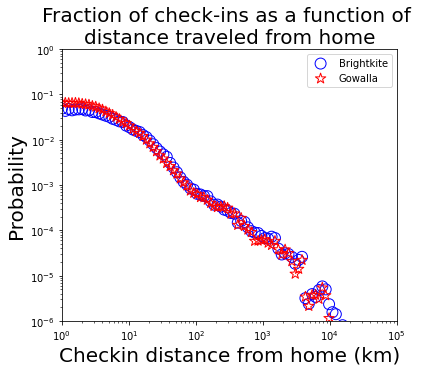

In [183]:
# Function that computes the distributions of the values in data and plots it using a scatter plot.
# The arguments are:
#    - data: the array containing the values for which we want to compute the distribution.
#    - ax: the axes of the plot on shich we will apply the scatter function.
#    - marker, color, m_size: type, edgecolor and size of the markers we want. m_size is set to 120 by default.
#    - bins_max, num_bins: max value for the logspace function, and number of values wanted for the bins. 
#                          Defalut values set respectively to 10^5 and 100 for this plot.
def plot_probability(data, ax, marker, color, label, m_size = 120, bins_max = pow(10,5), num_bins = 100):
    log_bins=np.logspace(0, np.log10(bins_max), num = num_bins)
    hist_values, bins = np.histogram(data, bins= log_bins, density=True)
    ax.scatter(bins[:-1], hist_values, marker= marker, s=m_size, facecolors='none', edgecolors=color, label=label)

# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, ax = plt.subplots(figsize=(6, 5))

# BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
plot_probability(b_checkins['dist_from_home'], ax, 'o', 'b', 'Brightkite')

# GOWALLA – computing and scatter plotting the distribution of home distances between friends.
plot_probability(g_checkins['dist_from_home'], ax, '*', 'r', 'Gowalla')

# Setting the axes' scales to be logarithmic.
ax.set_xscale("log")
ax.set_yscale("log")

#Setting the limits of the axes to match the ones in the paper's plot.
ax.set_xlim(10e-1, 10e4)
ax.set_ylim(10e-7, 10e-1)

# Naming the axes and resizing the labels
ax.set_xlabel('Checkin distance from home (km)', size=20)
ax.set_ylabel('Probability', size=20)

# Adding the color legend and the title of the plot.
ax.set_title("Fraction of check-ins as a function of \ndistance traveled from home", size=20)
ax.legend()

In [5]:
g_Temp.to_csv(r'./Data/g_final.txt.gz', compression = 'gzip')

In [6]:
b_temp.to_csv(r'./Data/b_final.txt.gz', compression = 'gzip')

# Plot the distribution of how far people tend to travel from their home on the special dates and on each continent

In [11]:
def get_dataframe_txt(name):
    return pd.read_csv(data_folder + name, compression='gzip', sep=',')
g_final = get_dataframe_txt('g_final.txt.gz')
b_final = get_dataframe_txt('b_final.txt.gz')

In [19]:
b_final = b_final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
g_final = g_final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)

In [30]:
b_final.head()

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,cell_home,count,lat_home,long_home,home_in_n_america,home_in_s_america,home_in_europe,home_in_asia,home_in_oceania,home_in_africa
0,0,2010-10-17 01:48:53+00:00,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True
1,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True
2,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True
3,0,2010-10-13 23:31:51+00:00,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True
4,0,2010-10-13 20:05:43+00:00,39.751300,-105.000121,d268093afe06bd7d37d91c4d436e0c40d217b20a,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True


In [29]:
g_final.head()

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,count_y,lat_home_y,long_home_y,home_in_n_america_y,home_in_s_america_y,home_in_europe_y,home_in_asia_y,home_in_oceania_y,home_in_africa_y,dist_from_home
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,5.746958
1,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,2.014631
2,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.018804
3,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.022902
4,0,2010-10-12T23:58:03Z,30.261599,-97.758581,15372,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.224318


In [31]:
#b_final ['checkin_time'] = b_final['checkin_time'].apply(lambda x : pd.to_datetime(x))
g_final ['checkin_time'] = g_final['checkin_time'].apply(lambda x : pd.to_datetime(x))

In [32]:
b_final.head()

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,cell_home,count,lat_home,long_home,home_in_n_america,home_in_s_america,home_in_europe,home_in_asia,home_in_oceania,home_in_africa
0,0,2010-10-17 01:48:53+00:00,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True
1,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True
2,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True
3,0,2010-10-13 23:31:51+00:00,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True
4,0,2010-10-13 20:05:43+00:00,39.751300,-105.000121,d268093afe06bd7d37d91c4d436e0c40d217b20a,True,False,False,False,False,...,"(220, 175)",223,39.762127,-104.983128,True,False,True,True,True,True


In [33]:
g_final.head()

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,count_y,lat_home_y,long_home_y,home_in_n_america_y,home_in_s_america_y,home_in_europe_y,home_in_asia_y,home_in_oceania_y,home_in_africa_y,dist_from_home
0,0,2010-10-19 23:55:27+00:00,30.235909,-97.795140,22847,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,5.746958
1,0,2010-10-17 23:42:03+00:00,30.255731,-97.763386,316637,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,2.014631
2,0,2010-10-17 19:26:05+00:00,30.263418,-97.757597,16516,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.018804
3,0,2010-10-16 18:50:42+00:00,30.274292,-97.740523,5535878,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.022902
4,0,2010-10-12 23:58:03+00:00,30.261599,-97.758581,15372,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.224318


In [34]:
b_final[['latitude', 'longitude']].to_csv(r'./Data/b_positions.csv.gz', compression = 'gzip')
g_final[['latitude', 'longitude']].to_csv(r'./Data/g_positions.csv.gz', compression = 'gzip')

In [48]:
world_map = plt.imread('./Data/world_map.png')

In [54]:
#BBox = (b_final.longitude.min(),b_final.longitude.max(),b_final.latitude.min(), b_final.latitude.max())
BBox = (-179,180,-89, 90)

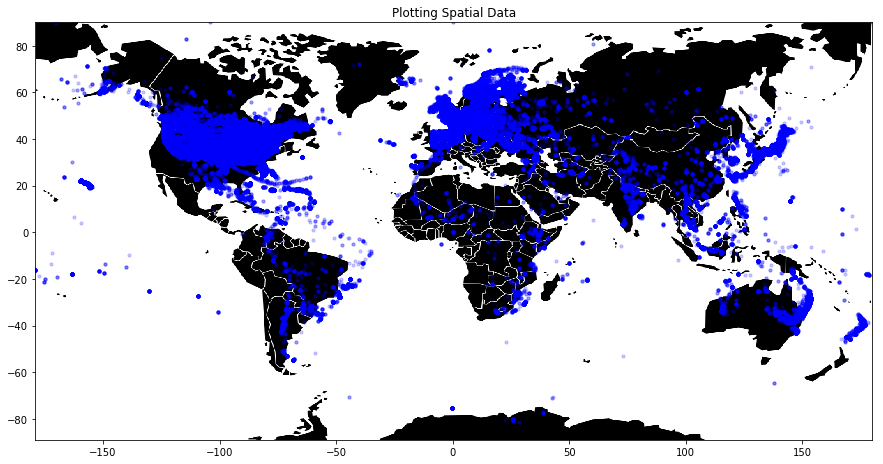

In [55]:
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(b_final.longitude, b_final.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(world_map, zorder=0, extent = BBox, aspect= 'equal')

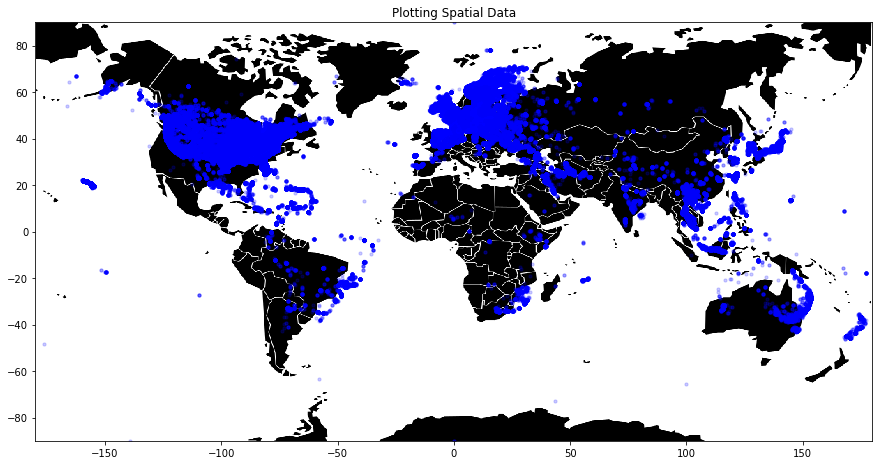

In [51]:
BBox = (-200,200,-100, 100)
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(g_final.longitude, g_final.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(world_map, zorder=0, extent = BBox, aspect= 'equal')